In [1]:
#import libraries
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy as ccrs

import scipy.stats as stats
import scipy.interpolate as interpolate
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [2]:
#load data
#era_data = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/streamfunction_1950-2022_JJA.nc")
era_data = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/streamfunction_1950-2022_JJA_WE.nc")
#import temperature data
era_max = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max_regrid.nc")
era_mean_temp = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_mean_regrid.nc")

In [3]:
#find daily maximum and daily mean streamfunction
era_daily = era_data.resample(time = '1D').max(skipna = True)
era_mean = era_data.resample(time = '1D').mean(skipna = True)

In [4]:
#find era climatology
era_clim = era_mean.groupby('time.dayofyear').mean(dim='time', skipna = True).sel(dayofyear = slice(152,244))

In [5]:
era_clim

<xarray.Dataset>
Dimensions:         (latitude: 41, longitude: 71, dayofyear: 93)
Coordinates:
  * latitude        (latitude) float64 70.0 69.0 68.0 67.0 ... 32.0 31.0 30.0
  * longitude       (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * dayofyear       (dayofyear) int64 152 153 154 155 156 ... 241 242 243 244
Data variables:
    streamfunction  (dayofyear, latitude, longitude) float32 -4.09e+07 ... 3....

In [6]:
#find streamfunction anomalies
lons = np.concatenate((np.arange(41), np.arange(360-30, 360, 1)))
sf_anom = era_daily.groupby('time.dayofyear') - era_clim
sf_anom_eur = sf_anom.sel(longitude = lons, latitude = slice(70,30))

Text(0.5, 1.0, 'Streamfunction Anomaly for June 29th 2019')

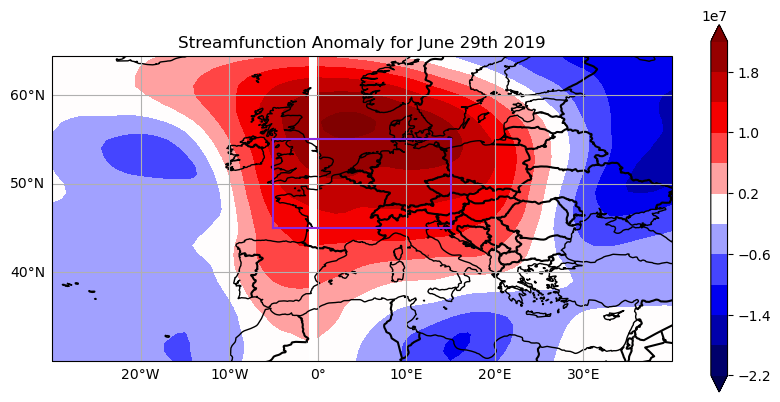

In [7]:
sf_test = sf_anom_eur.sel(time = '2019-06-29').streamfunction
fig = plt.figure(figsize = (10,15))
ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(sf_test.longitude, sf_test.latitude, sf_test.values,
                                    cmap = 'seismic', levels = np.linspace(-2.2e7, 2.2e7, 12), 
                                 transform = ccrs.PlateCarree(), extend = "both")

transform = ccrs.Orthographic(central_longitude = 5, central_latitude = 50)
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 60])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("Streamfunction Anomaly for June 29th 2019")

In [8]:
#make year and date array
summer_dates = np.arange('1950'+'-06-01', '1950'+'-09-01', np.timedelta64(1,'D'), dtype='datetime64[ns]')
years = np.arange(1951,2023,1)
for year in years:
    year = str(year)
    dates = np.arange(year+'-06-01', year+'-09-01', np.timedelta64(1,'D'), dtype='datetime64[ns]')
    summer_dates = np.concatenate((summer_dates, dates))

lons_dyn = np.concatenate((np.arange(20), np.arange(-30+360, 360)))
sf_summer = sf_anom_eur.sel(time = summer_dates, latitude = slice(60,30), longitude = lons_dyn)

In [9]:
# nan_days = np.array(['2020-08-31T00:00:00.000000000', '2016-08-31T00:00:00.000000000',
#        '2012-08-31T00:00:00.000000000', '2008-08-31T00:00:00.000000000',
#        '2004-08-31T00:00:00.000000000', '2000-08-31T00:00:00.000000000',
#        '1996-08-31T00:00:00.000000000', '1992-08-31T00:00:00.000000000',
#        '1988-08-31T00:00:00.000000000', '1984-08-31T00:00:00.000000000',
#        '1980-08-31T00:00:00.000000000', '1976-08-31T00:00:00.000000000',
#        '1972-08-31T00:00:00.000000000', '1968-08-31T00:00:00.000000000',
#        '1964-08-31T00:00:00.000000000', '1960-08-31T00:00:00.000000000',
#        '1956-08-31T00:00:00.000000000', '1952-08-31T00:00:00.000000000'],
#       dtype='datetime64[ns]')
# sf_summer = sf_summer.drop_sel(time = nan_days)

In [9]:
temp_lons = np.concatenate((np.arange(16),np.arange(-5+360,360,1)))
temp_lats = era_max.sel(latitude = slice(55,45), longitude = slice(-5,15)).latitude

In [10]:
#import data for trends
#monthly global mean temperatures
global_months = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_monthly_temperature_1940-2024_global.nc")
#land sea mask
lsm = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/europe_mask_0.5.nc")
small_mask = (lsm.sel(longitude = slice(-5,15), latitude = slice(55,45)).t2m)/(lsm.sel(longitude = slice(-5,15), 
                                                                                       latitude = slice(55,45)).t2m)
#find gwd
#weighting by latitude
weights = np.cos(np.deg2rad(global_months.latitude))
weighted_weights = weights/np.mean(weights)

weighted_temps = global_months.sel(expver = 1).groupby("latitude")*weighted_weights
weighted_global_mean = weighted_temps.t2m.sel(time = slice('1950', '2022')).mean(dim = ['latitude', 'longitude'])
weighted_yearly_mean = weighted_global_mean.groupby("time.year").mean()
weighted_rolling_mean = weighted_yearly_mean.rolling(year = 5, center=True, min_periods = 3).mean()
weighted_gwd_2022 = weighted_rolling_mean[-1]
weighted_gwd = weighted_rolling_mean - weighted_gwd_2022
#weighted_gwd

In [15]:
anlg_temps_sort.t2m

<xarray.DataArray 't2m' (time: 68)>
array([188.71785, 190.44969, 189.10202, 186.71785, 189.11887, 186.68315,
       188.22801, 189.19026, 187.87819, 189.07777, 188.90414, 189.46617,
       188.56978, 190.48436, 189.14578, 189.7872 , 189.35468, 189.9877 ,
       190.10112, 187.65747, 188.54652, 187.44217, 189.39711, 187.09987,
       190.89769, 186.77359, 189.38979, 190.02893, 189.06894, 190.75629,
       191.76942, 190.60551, 189.90662, 190.47859, 188.94958, 186.96837,
       189.62318, 188.09004, 190.93474, 190.80644, 187.96686, 189.65   ,
       191.06816, 188.91492, 188.65205, 188.34697, 189.7297 , 188.39856,
       188.97688, 189.88637, 187.91765, 189.42462, 190.3279 , 188.24916,
       187.77258, 190.50221, 192.60764, 189.1083 , 190.40318, 189.84444,
       193.33675, 188.94247, 189.72523, 190.06174, 191.67676, 191.97682,
       188.1127 , 190.01334], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-06-03 1950-08-21 ... 2021-08-11

In [19]:
#Find the Circulation Conditioned mean temperature trend b(x) for each day
all_days = sf_summer.time.values
b_x = []
counter = 0
for date in all_days: #for each X(d) in b(X(d))
    counter +=1
    ds_max = sf_summer
    # select day
    ind_sel = 0
    date_sel = date #ds_max.time[ind_sel].values
    # get year of day selected as str
    year_sel = ds_max.time[ind_sel].dt.year.values.astype('str').item()

    ## select data from this day
    ds_max_date = ds_max.sel(time = date_sel)

    ## Calculate ACC by hand instead of euclid. dist.
    num = (ds_max_date*ds_max).sum(dim=['latitude', 'longitude'], skipna = True)
    denom = (ds_max**2).sum(dim=['latitude','longitude'], 
                                     skipna = True)*(ds_max_date**2).sum(dim=['latitude','longitude'], skipna = True)
    corr = num/(denom**(1/2))
    ds_max_corr_sort = corr.sortby('streamfunction').streamfunction[::-1]  #reverse

    time_diffs = np.abs(ds_max_corr_sort.time.values.astype('datetime64[D]') - ds_max_date.time.values.astype('datetime64[D]'))
    diffs_sel = np.where(time_diffs > np.timedelta64(1,'D'))[0] #not including self analogues
    ds_max_corr_sel = ds_max_corr_sort[diffs_sel]
    ds_max_perc = ds_max_corr_sel[0:500] #top 500 analogue days (I don't know if this does anything)
    first_date = ds_max_perc.time.values[0] #select the 1st analogue
    anlg_dates = np.zeros(68,dtype='datetime64[ns]') #make array of teh 68 analogue days
    anlg_dates[0] = first_date
    time_index = 1 #index for each analogue in the anlg_dates array
    index = 1 #index to select date from ds_max_perc

    for date in anlg_dates:
        anlg = ds_max_perc[index].time
        #take the time difference between the proposed analogue and all other previous analogues in anlg_dates
        time_diff = np.abs(anlg.values.astype('datetime64[D]') - anlg_dates[0:time_index].astype('datetime64[D]'))
        check = time_diff > np.timedelta64(6,'D') #make boolean array of True/False asserting 6 day separtaion
        if check.sum() < time_index: #time index = # of points in the array so .sum() should = time index if all anlgs are 6 days apart
            #print('need to check')
            index += 1
            anlg = ds_max_perc[index].time
            time_diff = np.abs(anlg.values.astype('datetime64[D]') - anlg_dates[0:time_index].astype('datetime64[D]'))
            check = time_diff > np.timedelta64(6,'D')
            while check.sum() < time_index:
                #print('entered loop', time_index)
                index += 1
                anlg = ds_max_perc[index].time
                time_diff = np.abs(anlg.values.astype('datetime64[D]') - anlg_dates[0:time_index].astype('datetime64[D]'))
                check = time_diff > np.timedelta64(6,'D')
        else:
            index += 1
        anlg_dates[time_index] = anlg.time.values #append analogue to the array
        time_index += 1
        if time_index == 68:
            break
    anlg_temps_lat = era_mean_temp.sel(time = anlg_dates, latitude = slice(55,45), 
                                 longitude = slice(-5,15)).groupby('latitude')*np.cos(np.deg2rad(temp_lats))
    anlg_temps = anlg_temps_lat.mean(dim = ['longitude', 'latitude'])

    #take the linear regression
    anlg_temps_sort = anlg_temps.sortby('time')
    anlg_gwd_years = pd.DatetimeIndex(anlg_temps_sort.time).year
    anlg_gwd = weighted_rolling_mean.sel(year = anlg_gwd_years)
    regress = stats.linregress(anlg_gwd, anlg_temps_sort.t2m).slope
    b_x.append(regress)
    if counter % 500 == 0:
        print(counter)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


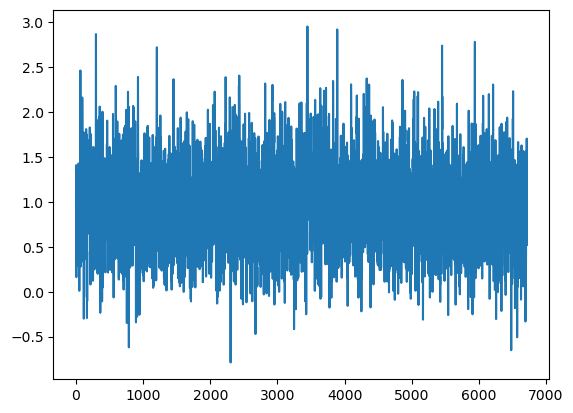

In [20]:
plt.plot(b_x)

In [21]:
a = (sf_summer.mean(dim = ['latitude', 'longitude']).drop_vars('dayofyear'))/(sf_summer.mean(dim = ['latitude', 'longitude']).drop_vars('dayofyear'))
b = a.groupby('time.year')*weighted_gwd
bx_gwd = (b_x*b).rename_vars(streamfunction = 't2m')#.drop_vars(['expver', 'year'])

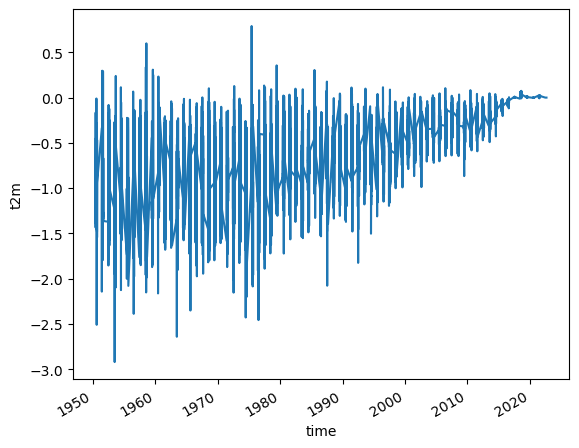

In [22]:
bx_gwd.t2m.plot()

In [ ]:
# test_days = sf_summer.time.values
# loop_number = 1
# for day in test_days:
#     #print(loop_number)
# # test with Correlation Coefficient
#     ds_max = sf_summer
#         # select day
#     ind_sel = 0
#     date_sel = day #ds_max.time[ind_sel].values
#         # get year of day selected as str
#     year_sel = ds_max.time[ind_sel].dt.year.values.astype('str').item()

#         ## select data from this day
#     ds_max_date = ds_max.sel(time = date_sel)

#         ## select rest of data, minus all dates in year selected
#         # Note: assuming there is only JJA in dataset
#     year_sel_all = np.arange(year_sel+'-06-01', year_sel+'-09-01', np.timedelta64(1,'D'), dtype='datetime64[ns]')
#     #ds_max_else = ds_max.drop_sel(time = year_sel_all)
#     #find which dates are nan
    
#     ## Calculate ACC by hand instead of euclid. dist.
#     ds_max_date_mean = ds_max_date.mean(dim=['latitude', 'longitude'],skipna = True)
#     ds_max_else_mean = ds_max_else.mean(dim=['latitude', 'longitude'],skipna = True)
# #     ds_max_date_anom = ds_max_date - ds_max_date_mean
# #     ds_max_else_anom = ds_max_else - ds_max_else_mean
#     num = (ds_max_date*ds_max_else).sum(dim=['latitude', 'longitude'], skipna = True)
#     denom = (ds_max_else**2).sum(dim=['latitude','longitude'], 
#                                  skipna = True)*(ds_max_date**2).sum(dim=['latitude','longitude'], skipna = True)
#     corr = num/(denom**(1/2))
#     ds_max_corr_sort = corr.sortby('streamfunction').streamfunction[::-1]  #reverse
# #     ## calculate correlation coeff. w/ all other days
# #     ds_max_r = xr.corr(ds_max_date.z, ds_max_else.z, dim = ["latitude", 'longitude'])

# #     #sort by correlation coefficient, reverse for highest correlation
# #     ds_max_r_sort = ds_max_r.sortby(ds_max_r)[::-1]

#     # take time difference between each adjacent point in sorted data
#     time_diffs = ds_max_corr_sort.time.values.astype('datetime64[D]') - ds_max_date.time.values.astype('datetime64[D]')
#     # find indices where time difference is > 14 days
#     time_diffs_inds_sel = np.where(np.abs(time_diffs) > np.timedelta64(14,'D'))[0]

#     #actual analogue date
#     anlg_date0 = ds_max_corr_sort.time.values[0]

#     # then next is where first time_diff > 14d
#     index = 0
#     anlg_date1 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#     anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index+1]]

#     index = 2
#     anlg_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

#     #check that dates 1 and 2 are at least 14 days apart
#     if anlg_diff12 < np.timedelta64(14, 'D'):
#         index = index + 1
#         anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#         new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))
#         #find new analogue
#         if new_diff12 < np.timedelta64(14, 'D'):
#             while new_diff12 < np.timedelta64(14, 'D'):
#                 index = index + 1
#                 anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#                 new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

#     anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#     anlg_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
#     anlg_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))

#     #make sure that the 3rd analogue day is also at least 14 days from the others
#     if anlg_diff13 < np.timedelta64(14, 'D') or anlg_diff23 < np.timedelta64(14, 'D'):
#         index = index + 1
#         anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#         new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
#         new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
#         if new_diff13 < np.timedelta64(14, 'D') or new_diff23 < np.timedelta64(14, 'D'):
#         #find new lowest analogue
#             while new_diff13 < np.timedelta64(14, 'D') or new_diff23 < np.timedelta64(14, 'D'):
#                 index+=1
#                 anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
#                 new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
#                 new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
#     # check dates
#     if np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]')) < np.timedelta64(14,'D'):
#         print("Error: analogues selected within 14 days of each other")
#     elif np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(14,'D'):
#         print("Error: analogues selected within 14 days of each other")
#     elif np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(14,'D'):
#         print("Error: analogues selected within 14 days of each other")
#         # print(anlg_date1)
#         # print(anlg_date2)
#         # print(anlg_date3)

#     ##  concat data from these three dates together
#     # Note: these should be temp arrays of analogue dates together (not ds_max again)
#     anlg_all = xr.concat([ds_max.sel(time = anlg_date1), ds_max.sel(time=anlg_date2), ds_max.sel(time=anlg_date3)], dim='N')
#     anlg_temps = era_max.sel(time = anlg_all.time)
#     anlg_temps1 = era_max.sel(time = anlg_date1).assign_coords(time=date_sel)
#     anlg_temps2 = era_max.sel(time = anlg_date2).assign_coords(time=date_sel)
#     anlg_temps3 = era_max.sel(time = anlg_date3).assign_coords(time=date_sel)
#     # take mean over new dimension, N
#     anlg_temps_avg = anlg_temps.mean(dim='N').assign_coords(time=date_sel)
#     # if this is the first time point, create new analogue temp field
#     #   that will be continually added to
#     if loop_number == 1:
#         anlg_mix = anlg_temps_avg
#         anlg_mix1 = anlg_temps1
#         anlg_mix2 = anlg_temps2
#         anlg_mix3 = anlg_temps3

#     else:
#         # if this is not first time point,
#         #    add to new analogues to ongoing temp field dataArray
#         anlg_mix = xr.concat([anlg_mix, anlg_temps_avg], dim='time')
#         anlg_mix1 = xr.concat([anlg_mix1, anlg_temps1], dim='time')
#         anlg_mix2 = xr.concat([anlg_mix2, anlg_temps2], dim='time')
#         anlg_mix3 = xr.concat([anlg_mix3, anlg_temps3], dim='time')
#     loop_number += 1
#     if loop_number % 500 == 0:
#         print(loop_number)
#         #print(anlg_date0)

- I think that the problem is that we were selecting "raw temperatures" for the analogues and then scaling the raw temperatures by the circulation conditioned temperature trend
- I think if we selected the analogues from detrended temperatures we would get the trend from the paper.

#### Enforce 6 day spacing between Analogues and no Self Analogues

In [23]:
T_s = era_max.groupby('time') - bx_gwd

In [24]:
test_days = sf_summer.time.values
loop_number = 1
for day in test_days:
    #print(loop_number)
# test with Correlation Coefficient
    ds_max = sf_summer
        # select day
    ind_sel = 0
    date_sel = day #ds_max.time[ind_sel].values
        # get year of day selected as str
    year_sel = ds_max.time[ind_sel].dt.year.values.astype('str').item()

        ## select data from this day
    ds_max_date = ds_max.sel(time = date_sel)

        ## select rest of data, minus all dates in year selected
        # Note: assuming there is only JJA in dataset
    year_sel_all = np.arange(year_sel+'-06-01', year_sel+'-09-01', np.timedelta64(1,'D'), dtype='datetime64[ns]')
    #ds_max_else = ds_max.drop_sel(time = year_sel_all)
    #find which dates are nan
    
    ## Calculate ACC by hand instead of euclid. dist.
    ds_max_date_mean = ds_max_date.mean(dim=['latitude', 'longitude'],skipna = True)
    ds_max_mean = ds_max.mean(dim=['latitude', 'longitude'],skipna = True)
#     ds_max_date_anom = ds_max_date - ds_max_date_mean
#     ds_max_else_anom = ds_max_else - ds_max_else_mean
    num = (ds_max_date*ds_max).sum(dim=['latitude', 'longitude'], skipna = True)
    denom = (ds_max**2).sum(dim=['latitude','longitude'], 
                                 skipna = True)*(ds_max_date**2).sum(dim=['latitude','longitude'], skipna = True)
    corr = num/(denom**(1/2))
    ds_max_corr_sort = corr.sortby('streamfunction').streamfunction[::-1]  #reverse
#     ## calculate correlation coeff. w/ all other days
#     ds_max_r = xr.corr(ds_max_date.z, ds_max_else.z, dim = ["latitude", 'longitude'])

#     #sort by correlation coefficient, reverse for highest correlation
#     ds_max_r_sort = ds_max_r.sortby(ds_max_r)[::-1]

    # take time difference between each adjacent point in sorted data
    time_diffs = ds_max_corr_sort.time.values.astype('datetime64[D]') - ds_max_date.time.values.astype('datetime64[D]')
    # find indices where time difference is > 14 days
    time_diffs_inds_sel = np.where(np.abs(time_diffs) > np.timedelta64(1,'D'))[0]

    #actual analogue date
    anlg_date0 = ds_max_corr_sort.time.values[0]

    # then next is where first time_diff > 14d
    index = 0
    anlg_date1 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
    anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index+1]]

    index = 2
    anlg_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

    #check that dates 1 and 2 are at least 14 days apart
    if anlg_diff12 < np.timedelta64(6, 'D'):
        index = index + 1
        anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
        new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))
        #find new analogue
        if new_diff12 < np.timedelta64(6, 'D'):
            while new_diff12 < np.timedelta64(6, 'D'):
                index = index + 1
                anlg_date2 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
                new_diff12 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]'))

    anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
    anlg_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
    anlg_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))

    #make sure that the 3rd analogue day is also at least 14 days from the others
    if anlg_diff13 < np.timedelta64(6, 'D') or anlg_diff23 < np.timedelta64(6, 'D'):
        index = index + 1
        anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
        new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
        new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
        if new_diff13 < np.timedelta64(6, 'D') or new_diff23 < np.timedelta64(6, 'D'):
        #find new lowest analogue
            while new_diff13 < np.timedelta64(6, 'D') or new_diff23 < np.timedelta64(6, 'D'):
                index+=1
                anlg_date3 = ds_max_corr_sort.time.values[time_diffs_inds_sel[index]]
                new_diff13 = np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
                new_diff23 = np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]'))
    # check dates
    if np.abs(anlg_date1.astype('datetime64[D]') - anlg_date2.astype('datetime64[D]')) < np.timedelta64(6,'D'):
        print("Error: analogues selected within 14 days of each other")
    elif np.abs(anlg_date1.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(6,'D'):
        print("Error: analogues selected within 14 days of each other")
    elif np.abs(anlg_date2.astype('datetime64[D]') - anlg_date3.astype('datetime64[D]')) < np.timedelta64(6,'D'):
        print("Error: analogues selected within 14 days of each other")
        # print(anlg_date1)
        # print(anlg_date2)
        # print(anlg_date3)

    ##  concat data from these three dates together
    # Note: these should be temp arrays of analogue dates together (not ds_max again)
    anlg_all = xr.concat([ds_max.sel(time = anlg_date1), ds_max.sel(time=anlg_date2), ds_max.sel(time=anlg_date3)], dim='N')
    anlg_temps = T_s.sel(time = anlg_all.time)
    anlg_temps1 = T_s.sel(time = anlg_date1).assign_coords(time=date_sel)
    anlg_temps2 = T_s.sel(time = anlg_date2).assign_coords(time=date_sel)
    anlg_temps3 = T_s.sel(time = anlg_date3).assign_coords(time=date_sel)
    # take mean over new dimension, N
    anlg_temps_avg = anlg_temps.mean(dim='N').assign_coords(time=date_sel)
    # if this is the first time point, create new analogue temp field
    #   that will be continually added to
    if loop_number == 1:
        anlg_mix = anlg_temps_avg
        anlg_mix1 = anlg_temps1
        anlg_mix2 = anlg_temps2
        anlg_mix3 = anlg_temps3

    else:
        # if this is not first time point,
        #    add to new analogues to ongoing temp field dataArray
        anlg_mix = xr.concat([anlg_mix, anlg_temps_avg], dim='time')
        anlg_mix1 = xr.concat([anlg_mix1, anlg_temps1], dim='time')
        anlg_mix2 = xr.concat([anlg_mix2, anlg_temps2], dim='time')
        anlg_mix3 = xr.concat([anlg_mix3, anlg_temps3], dim='time')
    loop_number += 1
    if loop_number % 500 == 0:
        print(loop_number)
        #print(anlg_date0)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [23]:
#import analogues
# anlg_mix1 = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/anlg_mix1.nc")
# anlg_mix2 = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/anlg_mix2.nc")
# anlg_mix3 = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/anlg_mix3.nc")

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 91, time: 6716)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.5 -29.0 -28.5 ... 39.0 39.5 40.0
  * latitude   (latitude) float32 75.0 74.5 74.0 73.5 ... 31.5 31.0 30.5 30.0
  * time       (time) datetime64[ns] 1950-06-01 1950-06-02 ... 2022-08-31
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-12 19:36:05 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [25]:
time_test = ds_max_corr_sort.time[0:2]
np.abs(time_test[0].astype('datetime64[D]') - time_test[1].astype('datetime64[D]'))

/tmp/95590.admin.default.domain/ipykernel_1774/592257617.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  np.abs(time_test[0].astype('datetime64[D]') - time_test[1].astype('datetime64[D]'))
/tmp/95590.admin.default.domain/ipykernel_1774/592257617.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to th

<xarray.DataArray 'time' ()>
array(86400000000000, dtype='timedelta64[ns]')

In [45]:
# c = (sf_summer.mean(dim = ['latitude', 'longitude']).drop_vars('dayofyear'))/(sf_summer.mean(dim = ['latitude', 'longitude']).drop_vars('dayofyear'))
# #d = a.groupby('time.year')#*weighted_gwd
# bx_gwd2 = (b_x*c).rename_vars(streamfunction = 't2m')#.drop_vars(['expver', 'year'])

In [46]:
# ahh = bx_gwd2.t2m.groupby('time.year')*weighted_gwd
# TXx - ahh.groupby('time.year')

In [44]:
bleh = bx_gwd2.groupby('time.year').mean().t2m
anlg_TXx4 = anlg_mix.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx4_w = anlg_TXx4.mean(dim = 'longitude').groupby('latitude')*anlg_weights
anlg_TXx4_weighted = anlg_TXx4_w.mean(dim = 'latitude').t2m
anlg_final = (anlg_TXx4_weighted - bleh*weighted_gwd)

(0.3017910133338714, 0.003680493143050735)

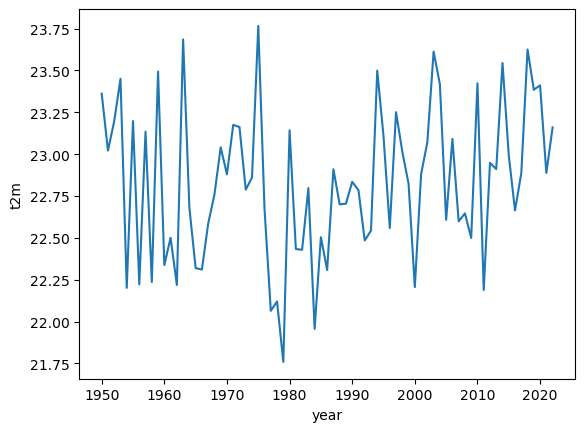

In [30]:
weights = era_max.latitude
ww = np.cos(np.deg2rad(weights))/np.mean(np.cos(np.deg2rad(weights)))

max_lat = era_max.groupby('latitude')*ww
max_temps = max_lat.mean(dim = ['latitude', 'longitude'])
T_s = (max_temps - ahh -273.15)
Ts_Xx = T_s.groupby('time.year').max()
Ts_r = stats.linregress(weighted_rolling_mean, Ts_Xx.t2m).slope
Ts_rt = stats.linregress(Ts_Xx.year.values, Ts_Xx.t2m).slope
Ts_Xx.t2m.plot()
plt.title("Detrended TXx temperatures")
Ts_r, Ts_rt

In [32]:
#subtract the factor
anlg_ts1 = anlg_mix1# - bx_gwd.t2m
anlg_ts2 = anlg_mix2# - bx_gwd.t2m
anlg_ts3 = anlg_mix3# - bx_gwd.t2m
anlg_ts = anlg_mix# - bx_gwd.t2m
#select western europe region, find yearly maximum and weight by latitude
#first analogue set
anlg_TXx1 = anlg_ts1.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
#analogue weights
anlg_w = np.cos(np.deg2rad(anlg_TXx1.latitude))
anlg_weights = anlg_w/np.mean(anlg_w)

anlg_TXx1_w = anlg_TXx1.mean(dim = 'longitude').groupby('latitude')*anlg_weights
anlg_TXx1_weighted = anlg_TXx1_w.mean(dim = 'latitude').t2m

#second analogue set
anlg_TXx2 = anlg_ts2.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx2_w = anlg_TXx2.mean(dim = 'longitude').groupby('latitude')*anlg_weights
anlg_TXx2_weighted = anlg_TXx2_w.mean(dim = 'latitude').t2m

#third analogue set
anlg_TXx3 = anlg_ts3.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx3_w = anlg_TXx3.mean(dim = 'longitude').groupby('latitude')*anlg_weights
anlg_TXx3_weighted = anlg_TXx3_w.mean(dim = 'latitude').t2m

#analogue series where the temperatures are averaged in the loop
anlg_TXx4 = anlg_ts.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max()*small_mask
anlg_TXx4_w = anlg_TXx4.mean(dim = 'longitude').groupby('latitude')*anlg_weights
anlg_TXx4_weighted = anlg_TXx4_w.mean(dim = 'latitude').t2m

#take average of all three sets of analogues for each year
anlg_TXx = (anlg_TXx1_weighted + anlg_TXx2_weighted + anlg_TXx3_weighted)/3

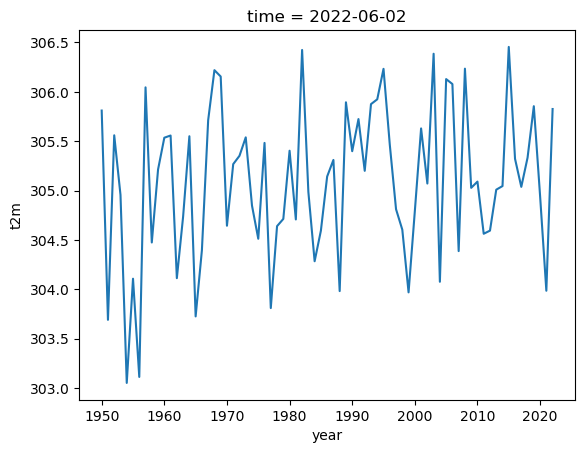

In [33]:
anlg_TXx.plot()

In [34]:
#find trend with all 3 analogues
trend = stats.linregress(weighted_gwd, anlg_TXx.T).slope
trend

0.4682788227254315

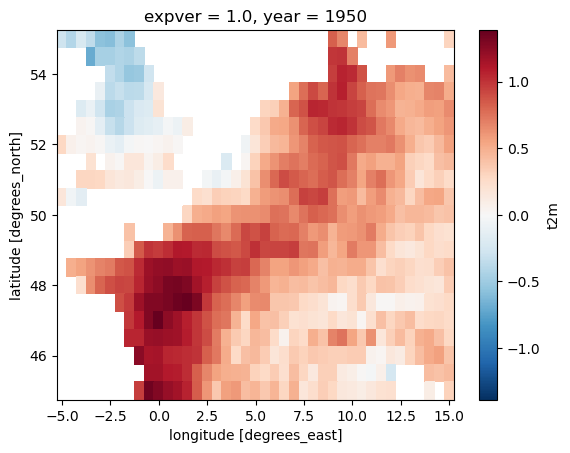

In [35]:
array1 = (np.copy(anlg_TXx1.t2m.values)*np.nan)[0,:,:,0]
array2 = (np.copy(anlg_TXx2.t2m.values)*np.nan)[0,:,:,0]
array3 = (np.copy(anlg_TXx3.t2m.values)*np.nan)[0,:,:,0]
array = (np.copy(anlg_TXx4.t2m.values)*np.nan)[0,:,:,0]
#calculate trends for the 1st set of analogues
for i, latitude in enumerate(anlg_TXx1.latitude):
    for j, longitude in enumerate(anlg_TXx1.longitude):
        gph = anlg_TXx1.t2m.values[:,i,j].T
        trend = stats.linregress(weighted_gwd, gph).slope
        array1[i,j] = trend
ds1 = (((anlg_TXx1.t2m[0,:,:]/anlg_TXx1.t2m[0,:,:]).drop_vars('time')[:,:,0])*array1)
#2nd set        
for i, latitude in enumerate(anlg_TXx2.latitude):
    for j, longitude in enumerate(anlg_TXx2.longitude):
        gph = anlg_TXx2.t2m.values[:,i,j].T
        trend = stats.linregress(weighted_gwd, gph).slope
        array2[i,j] = trend
ds2 = (((anlg_TXx2.t2m[0,:,:]/anlg_TXx2.t2m[0,:,:]).drop_vars('time')[:,:,0])*array2)
        
#3rd set
for i, latitude in enumerate(anlg_TXx3.latitude):
    for j, longitude in enumerate(anlg_TXx3.longitude):
        gph = anlg_TXx3.t2m.values[:,i,j].T
        trend = stats.linregress(weighted_gwd, gph).slope
        array3[i,j] = trend
ds3 = (((anlg_TXx3.t2m[0,:,:]/anlg_TXx3.t2m[0,:,:]).drop_vars('time')[:,:,0])*array3)

for i, latitude in enumerate(anlg_TXx4.latitude):
    for j, longitude in enumerate(anlg_TXx4.longitude):
        gph = anlg_TXx4.t2m.values[:,i,j].T
        trend = stats.linregress(weighted_gwd, gph).slope
        array[i,j] = trend
ds = (((anlg_TXx4.t2m[0,:,:]/anlg_TXx4.t2m[0,:,:]).drop_vars('time')[:,:,0])*array)
((ds1+ds2+ds3)/3).plot()

/tmp/95590.admin.default.domain/ipykernel_1774/662544692.py:34: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(j, orientation = "horizontal", extend = "both", shrink = 0.5, label = "TXx trend (degC/GWD)", ax = [ax1,ax2,ax3,ax4])


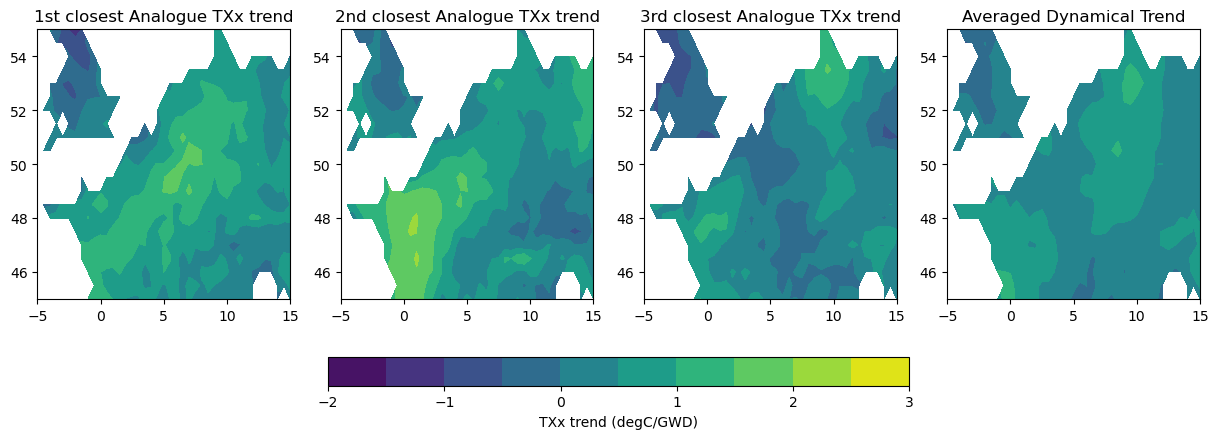

In [36]:
#plot all 3 arrays
plt.subplots(1,4,figsize = (15,5))
levels = np.linspace(-2,3,11)
ax1 = plt.subplot(1,4,1)
# j = ds1.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
j = plt.contourf(ds1.longitude, ds1.latitude, ds1.values, levels = levels)
plt.title("1st closest Analogue TXx trend")


ax2 = plt.subplot(1,4,2)
# j = ds1.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
plt.contourf(ds2.longitude, ds2.latitude, ds2.values, levels = levels)
plt.title("2nd closest Analogue TXx trend")
# ax = axs[1]
# ds2.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
# ax.set_title("2nd closest Analogue TXx trend")


ax3 = plt.subplot(1,4,3)
# j = ds1.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
plt.contourf(ds3.longitude, ds3.latitude, ds3.values, levels = levels)
plt.title("3rd closest Analogue TXx trend")
# ax = axs[2]
# ds3.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
# ax.set_title("3rd closest Analogue TXx trend")

ax4= plt.subplot(1,4,4)
# j = ds1.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
plt.contourf(ds.longitude, ds.latitude, ds.values, levels = levels)
plt.title("Averaged Dynamical Trend")
# ax = axs[2]
# ds3.plot(add_colorbar = False, vmin = -2, vmax = 2, ax = ax)
# ax.set_title("3rd closest Analogue TXx trend")
plt.colorbar(j, orientation = "horizontal", extend = "both", shrink = 0.5, label = "TXx trend (degC/GWD)", ax = [ax1,ax2,ax3,ax4])

In [37]:
test1 = anlg_mix1.sel(longitude = slice(-5,15), latitude = slice(55,45)).groupby("time.year").max().mean(
    dim = ['latitude', 'longitude']).t2m
trend_test = stats.linregress(weighted_gwd, test1)

In [38]:
a = (((anlg_TXx1.t2m[0,:,:]/anlg_TXx1.t2m[0,:,:]).drop_vars('time')[:,:,0])*array1)
b = a.mean(dim = 'longitude').groupby('latitude')*anlg_weights
array1_trend = float(b.mean(dim = 'latitude'))

c = (((anlg_TXx1.t2m[0,:,:]/anlg_TXx1.t2m[0,:,:]).drop_vars('time')[:,:,0])*array2)
d = c.mean(dim = 'longitude').groupby('latitude')*anlg_weights
array2_trend = float(d.mean(dim = 'latitude'))

e = (((anlg_TXx1.t2m[0,:,:]/anlg_TXx1.t2m[0,:,:]).drop_vars('time')[:,:,0])*array3)
f = e.mean(dim = 'longitude').groupby('latitude')*anlg_weights
array3_trend = float(f.mean(dim = 'latitude'))

g = (((anlg_TXx1.t2m[0,:,:]/anlg_TXx1.t2m[0,:,:]).drop_vars('time')[:,:,0])*array)
h = g.mean(dim = 'longitude').groupby('latitude')*anlg_weights
array_trend = float(h.mean(dim = 'latitude'))
mean_trend = np.mean((array1_trend, array2_trend, array3_trend))
print(np.mean((array1_trend, array2_trend, array3_trend)))
print(array1_trend, array2_trend, array3_trend)
print(array_trend)

0.46827882272542715
0.5740995341461554 0.6119543208958945 0.21878261313423156
0.389017673950804


In [39]:
time = np.linspace(1950, 2022, 73)
TXx = np.array([303.06125, 300.8648 , 304.40012, 302.06064, 300.56473, 301.5503 ,
        299.78998, 304.5593 , 300.64487, 303.63666, 300.87308, 302.48593,
        300.98578, 301.78052, 303.40918, 300.07336, 301.72928, 301.9841 ,
        302.46927, 302.75467, 301.6033 , 302.6268 , 301.36646, 302.45834,
        302.48315, 303.66544, 304.32443, 300.3028 , 300.61432, 300.7099 ,
        301.66064, 301.43814, 302.67642, 305.38687, 303.5553 , 302.1996 ,
        303.44507, 301.92047, 301.29086, 303.37216, 304.72327, 303.20007,
        304.29623, 301.23703, 304.59558, 304.7117 , 302.73224, 302.547  ,
        304.4615 , 303.25143, 303.80075, 303.72845, 303.76572, 306.8902 ,
        302.5182 , 303.92194, 305.74976, 303.55066, 302.54483, 304.1514 ,
        304.21677, 303.96576, 305.01968, 305.28152, 303.6588 , 306.4019 ,
        304.83112, 304.23816, 305.54166, 308.1024 , 305.8689 , 303.66074,
        305.53278])

In [40]:
m = stats.linregress(weighted_gwd,(TXx - bleh*weighted_gwd)).slope

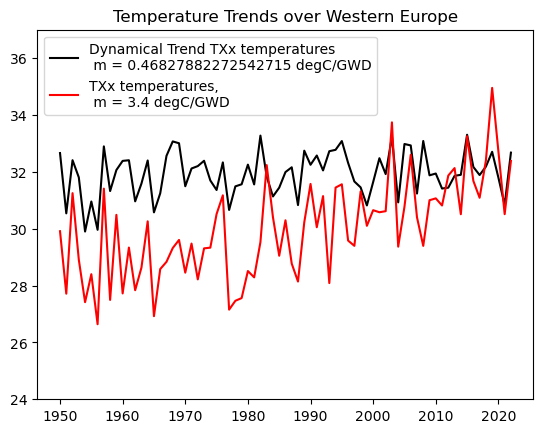

In [41]:
plt.plot(time, (anlg_TXx - 273.15), label = f'Dynamical Trend TXx temperatures \n m = {mean_trend} degC/GWD', color = "black")
#time = anlg_TXx.year
plt.plot(time,TXx - 273.15, label = "TXx temperatures, \n m = 3.4 degC/GWD", color = "red")
plt.ylim(24,37)
plt.title("Temperature Trends over Western Europe")
plt.legend()

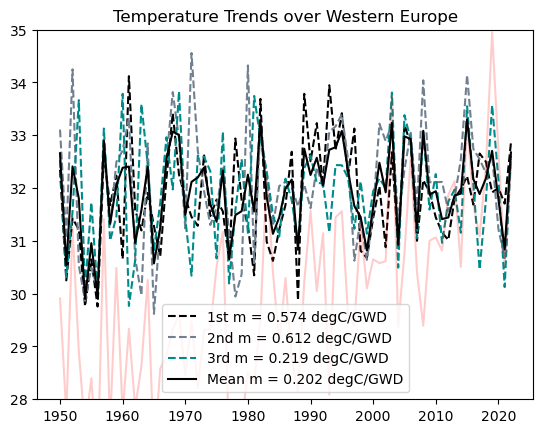

In [42]:
plt.plot(time, (anlg_TXx1_weighted - 273.15), label = f'1st m = {round(array1_trend,3)} degC/GWD', color = "black", linestyle = "dashed")
#time = anlg_TXx.year
plt.plot(time, (anlg_TXx2_weighted - 273.15), label = f'2nd m = {round(array2_trend,3)} degC/GWD', color = "slategrey", linestyle = "dashed")
plt.plot(time, (anlg_TXx3_weighted - 273.15), label = f'3rd m = {round(array3_trend,3)} degC/GWD', color = "darkcyan", linestyle = "dashed")
plt.plot(time,TXx - 273.15, color = "red", alpha = 0.2)
plt.plot(time, (anlg_TXx - 273.15), label = f'Mean m = {round(float(trend),3)} degC/GWD', color = "black")
plt.ylim(28,35)
plt.title("Temperature Trends over Western Europe")
plt.legend(loc = "lower center")

In [43]:
stats.linregress(time, anlg_TXx)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 73 and the array at index 1 has size 1